# Analysis of existing installations
The goal of this notebook find new features that could help inestigating

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from urllib.parse import urlparse
import pymysql
import os
import importlib
import seaborn as sns
import statsmodels.api as sm
from scipy import stats

import numpy as np

from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

importlib.reload(sns)

<module 'seaborn' from '/Users/noutneijmeijer/Documents/quatt_data_analysis/.venv/lib/python3.11/site-packages/seaborn/__init__.py'>

## data loading
input:
- set of features from hubspot
- set of features and savings calculation from internal api
- daily aggregated values of cics
- cic production dataset, to link cic id to ordernumber

Output:
df_cic: 1 row is 1 day of data, all features of a cic(installation) are merged onto that frame

In [14]:
# get data from mysql or local
if os.path.isfile('./data/cic_data.csv'):
    # load csv file
    df_cic = pd.read_csv('./data/cic_data.csv')

else:
    MYSQL_URL = os.environ['MYSQLDEV']
    parsed_mysql_url = urlparse(MYSQL_URL)

    try:
        connection = pymysql.connect(host=parsed_mysql_url.hostname,
                                    user=parsed_mysql_url.username,
                                    password=parsed_mysql_url.password,
                                    database=parsed_mysql_url.path[1:],
                                    port=parsed_mysql_url.port,
                                    autocommit=True)
        cursor = connection.cursor()
        if cursor.connection:
            # get energyConsumption
            cursor.execute('''SELECT * FROM cic_data_daily''')
            fields = [field_md[0] for field_md in cursor.description]
            result = [dict(zip(fields,row)) for row in cursor.fetchall()]
            df_cic = pd.DataFrame(result)
            df_cic.to_csv('./data/cic_data.csv', index=False)
    except:
        print("Error while connecting to MySQL")
    finally:
        cursor.close()
        connection.close()

In [15]:
# load expected savings data:
df_savings = pd.read_csv('./data/EnergyConsumption_test_data2.csv')
df_hubspot = pd.read_csv('./data/hubspot_data.csv')
df_cic_prod = pd.read_csv('./data/prod_cic.csv')

# merge df_savings with df_cic
df_hubspot['orderNr'] = df_hubspot['Deal Name'].str.extract(r'.*(QUATT\d+)')
df_savings = pd.merge(df_savings, df_cic_prod, left_on='orderNr', right_on='orderNumber', how='left')
df_savings = pd.merge(df_savings, df_hubspot, left_on='orderNr', right_on='orderNr', how='left')
df_cic = pd.merge(df_cic, df_savings, left_on='cic_id', right_on='id_y', how='left')



## Enriching the data

Addition of calculated values: COP, heat generated etc.  



In [16]:
df_cic['date'] = pd.to_datetime(df_cic['date'], format='%Y-%m-%d')

# add heat demand and month to dataframe
df_cic['heat_delivered'] = df_cic[['hp1_heat_generated', 'hp2_heat_generated', 'boiler_heat_generated']].sum(axis=1).astype(float)
df_cic['hp_heat_generated'] = df_cic[['hp1_heat_generated', 'hp2_heat_generated']].sum(axis=1).astype(float)
df_cic['hp_energy_consumed'] = df_cic[['hp1_energy_consumed', 'hp2_energy_consumed']].sum(axis=1).astype(float)
df_cic['perc_by_hp'] = (df_cic[['hp1_heat_generated', 'hp2_heat_generated']].sum(axis=1) / df_cic['heat_delivered']).astype(float)
df_cic['COP'] = (df_cic[['hp1_heat_generated', 'hp2_heat_generated']].sum(axis=1) / (df_cic[['hp1_energy_consumed', 'hp2_energy_consumed']].sum(axis=1))).astype(float)
df_cic['month'] = df_cic['date'].dt.month
df_cic['dd_month'] = df_cic['month'].apply(lambda x: 0.8 if x in [4, 5, 6, 7, 8, 9] else (1 if x in [3, 10] else 1.1)) # month weight factor as used in degree days method
df_cic['aardgas_verbruik_cat'] = df_cic['aardgas_verbruik'].apply(lambda x: 0 if x < 1000 else (1 if x < 2000 else (2 if x < 3000 else 3)))
df_cic['outside_temperature_avg'] = df_cic['outside_temperature_avg'].astype(float)

## preprocessing

Imputation: 
- Missing values: numberOfHeatPumps = 1, 'Zone regeling'=Nee  

Merging values:
- Weet niet, weet ik niet, none -> unknown
- Bouwjaar in 4 categories

Ordinal encoding:
- added ordinal encoding column for woning_type, zone_regeling, bouwjaar

One hot encoding:
- added OH encoding for afgiftesysteem, woningcomfort (because they can have multiple values)

In [17]:
# filling Nan values
df_cic['numberOfHeatPumps'].fillna(1, inplace=True)
df_cic['Zone regeling'].fillna('Nee', inplace=True)

# preprocess hubspot data
# merge 'Weet niet' and 'Weet ik niet' and 'nan' values to -> unkown
replacement_dict = {None: 'unknown', 
                    'Weet niet': 'unknown',
                    'Weet ik niet': 'unknown'}
df_cic.replace({'Spouwmuurisolatie': replacement_dict,
                    'Muurisolatie aan de binnen- of buitenkant': replacement_dict,
                    'Dakisolatie': replacement_dict,
                    'Vloerisolatie': replacement_dict,
                    'Dubbel glas': replacement_dict,
                    'HR++ glas': replacement_dict,
                    }, inplace=True)

# rename long column
df_cic.rename(columns={'Muurisolatie aan de binnen- of buitenkant': 'Muurisolatie'}, inplace=True)

# add ordinal encoding for categorical variables
df_cic['woning_type_ordinal'] = df_cic['woning_type'].map({'Vrijstaande woning': 0,
                                         '2-onder-1-kap': 1,
                                         'Hoekwoning': 2,
                                         'Tussenwoning': 3,
                                         'Appartement': 4})

df_cic['Zone_regeling_ordinal'] = df_cic['Zone regeling'].map({'Nee': 0,
                                             'Ja': 1,
                                             None: 0})

df_cic['bouwjaar'] = df_cic['bouwjaar'].map({'Voor 1970': 'Voor 1970',
                                            'voor 1970': 'Voor 1970',
                                            'Tussen 1970 en 1990': 'Tussen 1970 en 1990',
                                            '1970-1990': 'Tussen 1970 en 1990',
                                            '1974': 'Tussen 1970 en 1990',
                                            '1980': 'Tussen 1970 en 1990',
                                            'Tussen 1990 en 2000': 'Tussen 1990 en 2000',
                                            'Tussen 1995': 'Tussen 1990 en 2000',
                                            'Na 2000': 'Na 2000',
                                            '2000': 'Na 2000',
                                            '2005': 'Na 2000',
                                            '2010': 'Na 2000'})
df_cic['bouwjaar_ordinal'] = df_cic['bouwjaar'].map({'Voor 1970': 0,
                                   'Tussen 1970 en 1990': 1,
                                   'Tussen 1990 en 2000': 2,
                                   'Na 2000': 3})

# One hot encoding for categorical variables with multiple values
df_cic = pd.merge(df_cic, df_cic['afgiftesysteem'].str.replace('; ',';').str.get_dummies(sep=';'), left_index=True, right_index=True)
df_cic = pd.merge(df_cic, df_cic['Woning comfort'].str.replace('; ',';').str.get_dummies(sep=';'), left_index=True, right_index=True)


## visualisation


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


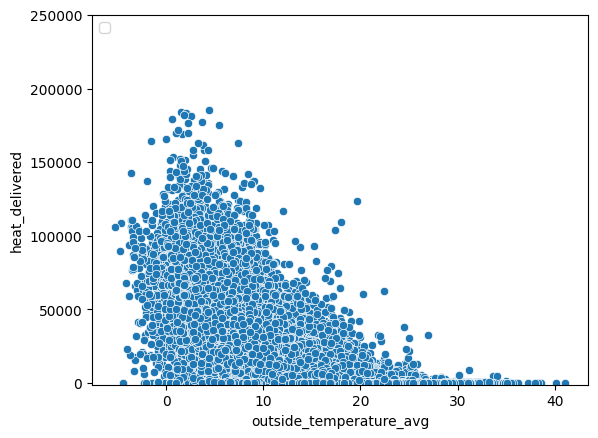

In [18]:


# scatter plot of heat demand per temperature including linear regression
sns.scatterplot(x='outside_temperature_avg', y='heat_delivered', data=df_cic)
plt.legend(loc='upper left')
plt.ylim([-1000, 250000])
plt.show()

(-0.1, 1.1)

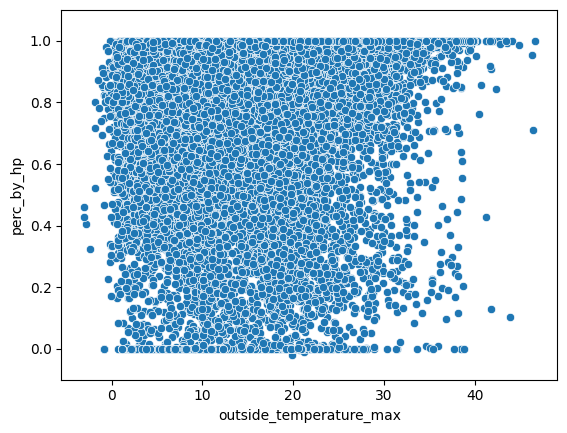

In [19]:
# scatter plot of perc_by_hp per temperature
sns.scatterplot(x='outside_temperature_max', y='perc_by_hp', 
           data=df_cic[df_cic['heat_delivered']>1000])
plt.ylim([-0.1, 1.1])

(0.0, 10.0)

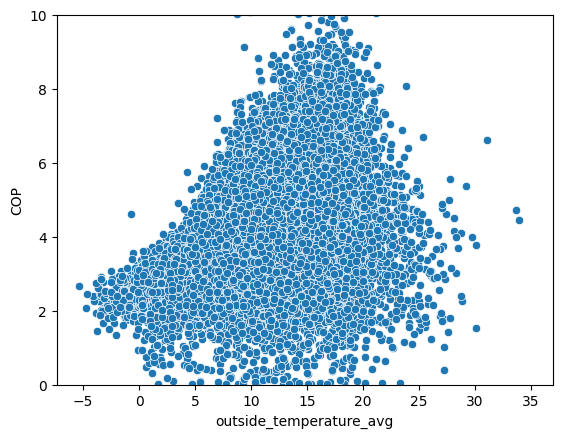

In [20]:
# scatter plot of COP per temperature
COP_temp = sns.scatterplot(x='outside_temperature_avg', y='COP', 
           data=df_cic[(df_cic['COP']>0) & (df_cic['heat_delivered']>1000)])
plt.ylim([0,10])

## Cleaning of data
- Selecting a subset of features (columns)
- select a set of cics for which days of heating > 50
- select those where certain values are not zero

In [ ]:
# drop rows that are compiled of inclomplete data (get rid of commissioning)
df_cic = df_cic[df_cic['number_of_rows']<24].drop(axis=0)


In [111]:
df_cic[(df_cic['hp1_active']==0) & (df_cic['hp2_active']==0) & (df_cic['boiler_active']==0) & (df_cic['heat_delivered']>0)]

,cic_id,created_at_x,updated_at_x,date,hp1_energy_consumed,hp1_heat_generated,hp1_active,hp2_energy_consumed,hp2_heat_generated,hp2_active,...,Convectoren aan de wand,Convectoren in de vloer,Radiatoren,Vloerverwarming,Goed,Soms te koud,Soms te warm,Vaak te koud,Vaak te warm,on
131,CIC-0043864c-e94c-59d1-9f86-8193abf8878c,2023-09-26 11:25:44,2023-09-26 11:25:44,2023-07-28,80.645449,51.322360,0.0,81.282715,55.024527,0.0,...,0,0,1,1,1,0,0,0,0,1
1793,CIC-0149310a-3e38-5d25-8a76-5470233bf5d3,2023-09-26 11:25:52,2023-09-28 12:49:32,2023-09-25,129.778776,17.740042,0.0,128.417489,19.580510,0.0,...,0,0,0,0,0,0,0,0,0,1
3320,CIC-02f0191e-e2bf-5a4f-b154-1dcb8a792651,2023-09-26 11:26:32,2023-09-26 11:26:32,2023-09-06,83.631940,106.650432,0.0,90.070284,117.932698,0.0,...,0,0,1,1,1,0,0,0,0,1
3913,CIC-037f0337-2765-5c7a-8a73-c98dce482661,2023-09-26 11:26:32,2023-09-26 11:26:32,2023-07-11,125.304352,394.184119,0.0,134.009230,377.716696,0.0,...,0,0,1,1,1,1,0,0,0,1
9816,CIC-080e9389-7d68-55aa-a2b9-d42786592f16,2023-09-26 11:27:14,2023-09-26 11:27:14,2023-08-07,353.424519,602.400975,0.0,314.209524,584.700770,0.0,...,1,0,0,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301490,CIC-fb3eb458-3d82-5d22-aa1a-b9179247f39e,2023-09-26 12:03:55,2023-09-26 12:03:55,2023-07-28,137.387173,27.555452,0.0,125.292868,0.000000,0.0,...,0,0,1,1,1,0,0,0,0,1
301526,CIC-fb3eb458-3d82-5d22-aa1a-b9179247f39e,2023-09-26 12:03:55,2023-09-26 12:03:55,2023-09-02,125.460710,0.000000,0.0,142.596640,88.843461,0.0,...,0,0,1,1,1,0,0,0,0,1
304898,CIC-fdcc14c7-0fd3-5041-8647-adb40b77caa3,2023-09-26 12:04:34,2023-09-26 12:04:34,2023-07-26,113.940372,75.606899,0.0,89.103575,69.498627,0.0,...,0,0,0,1,1,0,0,0,0,1
304959,CIC-fdcc14c7-0fd3-5041-8647-adb40b77caa3,2023-09-26 12:04:34,2023-09-28 13:10:52,2023-09-25,145.542472,60.345197,0.0,126.467744,0.000000,0.0,...,0,0,0,1,1,0,0,0,0,1


In [113]:
df_cic[(df_cic['hp1_active']==0) & (df_cic['hp2_active'].isna())]

0         True
2         True
3         True
4         True
5         True
          ... 
307212    True
307213    True
307214    True
307217    True
307218    True
Name: hp2_active, Length: 245523, dtype: bool

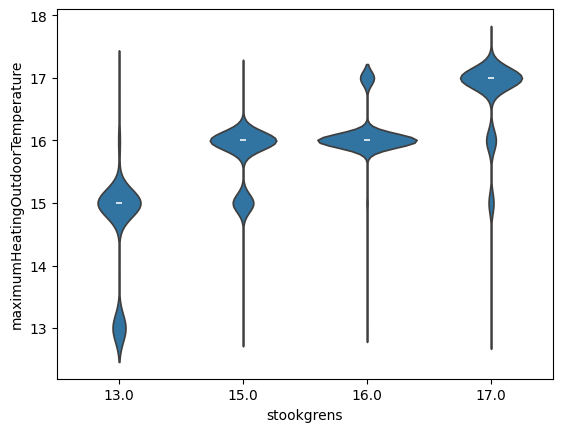

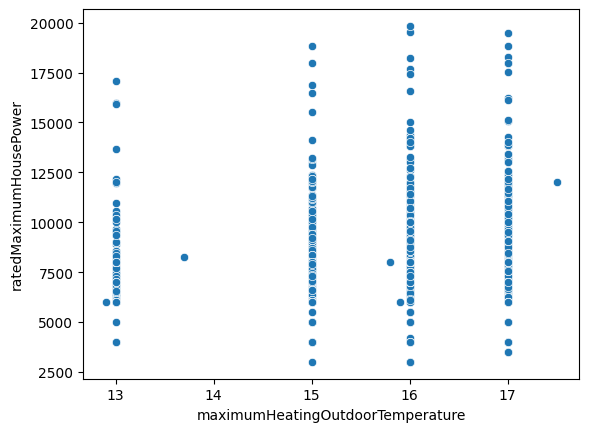

In [21]:
# print(df_cic.columns.values)

df_cic_facts = df_cic.groupby('cic_id').aggregate({'stookgrens': 'median',
                                                   'maximumHeatingOutdoorTemperature': 'median',
                                                   'ratedMaximumHousePower': 'median'})
# mamximumHeatingOutdoorTemperature, ratedMaximumHousePower, stookgrens
# sns.scatterplot(data=df_cic, x='stookgrens', y='maximumHeatingOutdoorTemperature', hue='ratedMaximumHousePower')

# boxplot of same parameters
sns.violinplot(data=df_cic_facts, x='stookgrens', y='maximumHeatingOutdoorTemperature')
plt.show()

sns.scatterplot(data=df_cic_facts, x='maximumHeatingOutdoorTemperature', y='ratedMaximumHousePower')
plt.show()

In [22]:
df_cic['usePricingToLimitHeatPump'].isna().sum() # what value is used for missing values?

35144

In [23]:
df_cic[df_cic['aardgas_verbruik'] != df_cic['Aardgas']][['cic_id','Aardgas','aardgas_verbruik']].value_counts()

cic_id                                    Aardgas  aardgas_verbruik
CIC-b0dcac9c-0352-5406-8eb2-621bdd2c62c5  2500.0   2000.0              147
dtype: int64

In [110]:
len(df_cic[df_cic['number_of_rows']<24])

17158

In [108]:
df_cic[(df_cic['heat_delivered']>0) &
       # (df_cic['outside_temperature_avg']>20) &
       (df_cic['room_set_temperature_max']<df_cic['room_temperature_min'])
       ][[
           'cic_id',
           'heat_delivered',
           'outside_temperature_avg',
           'outside_temperature_avg',
       'outside_temperature_min',
       'outside_temperature_max',
       'room_set_temperature_max',
       'room_set_temperature_avg',
       'room_set_temperature_min',
       'room_temperature_max',
       'room_temperature_avg',
       'room_temperature_min']]

,cic_id,heat_delivered,outside_temperature_avg,outside_temperature_avg,outside_temperature_min,outside_temperature_max,room_set_temperature_max,room_set_temperature_avg,room_set_temperature_min,room_temperature_max,room_temperature_avg,room_temperature_min
1,CIC-00149d9a-da31-5e61-844d-3e818b8a2ded,149.602126,27.898,27.898,23.705,29.467,20.144,18.904,18.0,24.509,24.141,23.657
32,CIC-00149d9a-da31-5e61-844d-3e818b8a2ded,1.359693,26.775,26.775,16.818,40.552,19.000,18.646,18.0,26.286,25.502,24.997
41,CIC-00149d9a-da31-5e61-844d-3e818b8a2ded,1.069653,22.387,22.387,16.483,33.506,19.000,18.646,18.0,25.101,24.880,24.599
57,CIC-00149d9a-da31-5e61-844d-3e818b8a2ded,10.744160,19.367,19.367,14.375,27.803,19.000,18.646,18.0,23.813,23.164,22.755
67,CIC-00149d9a-da31-5e61-844d-3e818b8a2ded,0.913699,23.128,23.128,15.194,32.882,19.000,18.646,18.0,24.731,24.026,23.341
...,...,...,...,...,...,...,...,...,...,...,...,...
306712,CIC-ffaf7c21-d3e1-5c0f-b3d8-58d66613687f,1202.952756,16.785,16.785,13.517,20.542,19.726,18.655,18.0,21.629,21.382,21.140
306776,CIC-ffd3bdd6-fd98-54cc-ab62-6a89aa0e16fd,999.967758,9.267,9.267,8.358,10.734,17.219,16.852,16.0,18.870,17.998,17.609
306787,CIC-ffd3bdd6-fd98-54cc-ab62-6a89aa0e16fd,2566.030873,10.504,10.504,4.213,14.820,16.000,16.000,16.0,17.148,16.667,16.177
307055,CIC-ffd4679f-365a-5536-8817-62509ce33977,1051.333755,16.659,16.659,14.496,19.919,20.316,18.628,18.0,21.868,21.597,21.449


In [24]:
# get a subset of cic_data with cic's that have enough rows with non zero heat generated
df_cic_subset = df_cic[['cic_id',
                        'maximumHeatingOutdoorTemperature',
                        'ratedMaximumHousePower',
                        'date',
                        'heat_delivered',
                        'hp_heat_generated',
                        'hp_energy_consumed',
                        'perc_by_hp',
                        'COP',
                        'outside_temperature_avg',
                        'outside_temperature_min',
                        'outside_temperature_max',
                        'room_set_temperature_max',
                        'room_set_temperature_avg',
                        'room_set_temperature_min',
                        'room_temperature_max',
                        'room_temperature_avg',
                        'room_temperature_min',
                        'numberOfHeatPumps',
                        'aardgas_verbruik',
                        'bouwjaar',
                        'woning_type',  
                        'oppervlakte',
                        'afgiftesysteem',
                        'geschiktheidscategorie',
                        'Zone regeling',
                        'month']]

# add count of rows where heat_delivered > 0 per cic
df_cic_subset['rows_per_cic_heating'] = df_cic_subset.groupby('cic_id')['heat_delivered'].transform(lambda x: x[x>0].count())
df_cic_subset = df_cic_subset[df_cic_subset['rows_per_cic_heating']>50]
# drop rows where tempearature avg is nan
df_cic_subset = df_cic_subset[df_cic_subset['outside_temperature_avg'].notna()]

/var/folders/0m/6_0b79q57177vdz5tjzlnt1w0000gn/T/ipykernel_93073/43802628.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cic_subset['rows_per_cic_heating'] = df_cic_subset.groupby('cic_id')['heat_delivered'].transform(lambda x: x[x>0].count())


## select data to train model

In [87]:
# copy only rows with correct features
X = (df_cic[
        (df_cic['outside_temperature_avg']<20) &
      #   (df_cic['aardgas_verbruik']>100) &
      #   (df_cic['aardgas_verbruik']<6000) &
        (df_cic['outside_temperature_avg'].notna()) &
        (df_cic['Elektriciteit'].notna())]
                                  # feature list
                                  [[
                                      # features from cic measurements
                                      'outside_temperature_avg',
                                      'outside_temperature_min',
                                      'outside_temperature_max',
                                      'room_set_temperature_max',
                                      'room_set_temperature_avg',
                                      'room_set_temperature_min',
                                      'room_temperature_max',
                                      'room_temperature_avg',
                                      'room_temperature_min',
                                      'month',
                                      # features from cic data
                                      'numberOfHeatPumps',
                                      # features from savings calc.
                                      'referentie_warmtevraag_per_m2',
                                      # 'geschiktheid_woning',  # remove
                                      'aardgas_verbruik',
                                      'bouwjaar',
                                      'woning_type',
                                      'oppervlakte',
                                      'afgiftesysteem',
                                      'geschiktheidscategorie',  # remove
                                      'referentie_warmtevraag',
                                      'stookgrens',  # remove
                                      # features from hubspot
                                      'Spouwmuurisolatie',
                                      'Muurisolatie',
                                      'Dakisolatie',
                                      'Vloerisolatie',
                                      'Dubbel glas',
                                      'HR++ glas',
                                      'Zone regeling',
                                      'Woning comfort',
                                      'Elektriciteit'
                                      ]]
)



# select target variable
y =  (df_cic[
        (df_cic['outside_temperature_avg']<20) &
      #   (df_cic['aardgas_verbruik']>100) &
      #   (df_cic['aardgas_verbruik']<6000) &
        (df_cic['outside_temperature_avg'].notna()) &
        (df_cic['Elektriciteit'].notna())]
                                  [['hp_heat_generated']] #,
                                    # 'COP',
                                    # 'perc_by_hp',
                                    # 'hp_energy_consumed']]
)

# replacing negative values can be needed for some model types
# y = np.max([y, np.zeros(y.shape)], axis=0) # replace negative values with 0

In [88]:
# handling categorical features
# impute nan values in categorical features


# Ordinal encoding
X['woning_type_ordinal'] = X['woning_type'].map({'Vrijstaand': 0,
                                         '2-onder-1-kap': 1,
                                         'Hoekwoning': 2,
                                         'Tussenwoning': 3,
                                         'Appartement': 4})

X['Zone_regeling_ordinal'] = X['Zone regeling'].map({'Nee': 0,
                                             'Ja': 1,
                                             None: 0})

X['bouwjaar_ordinal'] = X['bouwjaar'].map({'Voor 1970': 0,
                                   'voor 1970': 0,
                                   'Tussen 1970 en 1990': 1,
                                   '1970-1990': 1,
                                   '1974': 1,
                                   '1980': 1,
                                   'Tussen 1990 en 2000': 2,
                                   'Tussen 1995': 2,
                                   'Na 2000': 3,
                                   '2000': 3,
                                   '2005': 3,
                                   '2010': 3})

# isolation parameters to ordinal encoding
ordinal_mapping = {
    'unknown': 0,
    'Nee': 1, 
    'Ja (meer dan 10 jaar geleden geplaatst)': 2, 
    'Ja (minder dan 10 jaar geleden geplaatst)': 3
}

ordinal_columns = ['Spouwmuurisolatie', 'Muurisolatie', 'Dakisolatie', 'Vloerisolatie', 'Dubbel glas', 'HR++ glas']

for column in ordinal_columns:
    X[column] = X[column].fillna('unknown').map(ordinal_mapping)


# 1 hot encode categorical features
X = pd.merge(X, X['afgiftesysteem'].str.replace('; ',';').str.get_dummies(sep=';'), left_index=True, right_index=True)
X = pd.merge(X, X['Woning comfort'].str.replace('; ',';').str.get_dummies(sep=';'), left_index=True, right_index=True)

# X = pd.merge(X, pd.get_dummies(X[[
#                                   'geschiktheidscategorie',
#                                   'stookgrens'
#                                   ]].astype(str)), 
#                                   left_index=True, right_index=True)
# X = pd.merge(X, pd.get_dummies(X[[
#                                   # 'geschiktheid_woning',
#                                 #   'bouwjaar',
#                                 #   'woning_type',
#                                   # 'Spouwmuurisolatie',
#                                   # 'Muurisolatie',
#                                   # 'Dakisolatie',
#                                   # 'Vloerisolatie',
#                                   # 'Dubbel glas',
#                                   # 'HR++ glas',
#                                   # 'Zone regeling'
#                                   ]]), 
#                                   left_index=True, right_index=True)



# remove categorical features
X = X.drop(['afgiftesysteem',
            # 'geschiktheid_woning',
            'bouwjaar',
            'woning_type',
            # 'Spouwmuurisolatie',
            # 'Muurisolatie',
            # 'Dakisolatie',
            # 'Vloerisolatie',
            # 'Dubbel glas',
            # 'HR++ glas',
            'Zone regeling',
            'Woning comfort',
            # 'geschiktheidscategorie',
            # 'stookgrens'
            ], axis=1)

# rename long columns names
# X.columns = X.columns.str.replace(r"(.*)Ja \(meer dan 10 jaar geleden geplaatst\)", r"\1Ja >10")
# X.columns = X.columns.str.replace(r"(.*)Ja \(minder dan 10 jaar geleden geplaatst\)", r"\1Ja <10")


In [89]:
# merge frames and export to csv
df_total = pd.merge(X, y, left_index=True, right_index=True)
df_total = df_total.dropna(axis=0)
df_total.to_csv('./data/export/12degree.csv', index=False)

# split df_total back into X and y
X = df_total.drop(['hp_heat_generated'], axis=1)
y = df_total[['hp_heat_generated']]

## visualize heat generated temperature and month dependency

/var/folders/0m/6_0b79q57177vdz5tjzlnt1w0000gn/T/ipykernel_93073/3960069833.py:5: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.
  sns.violinplot(data=df_cic, # [df_cic['month'].isin([5, 6, 7, 8, 9, 10])]


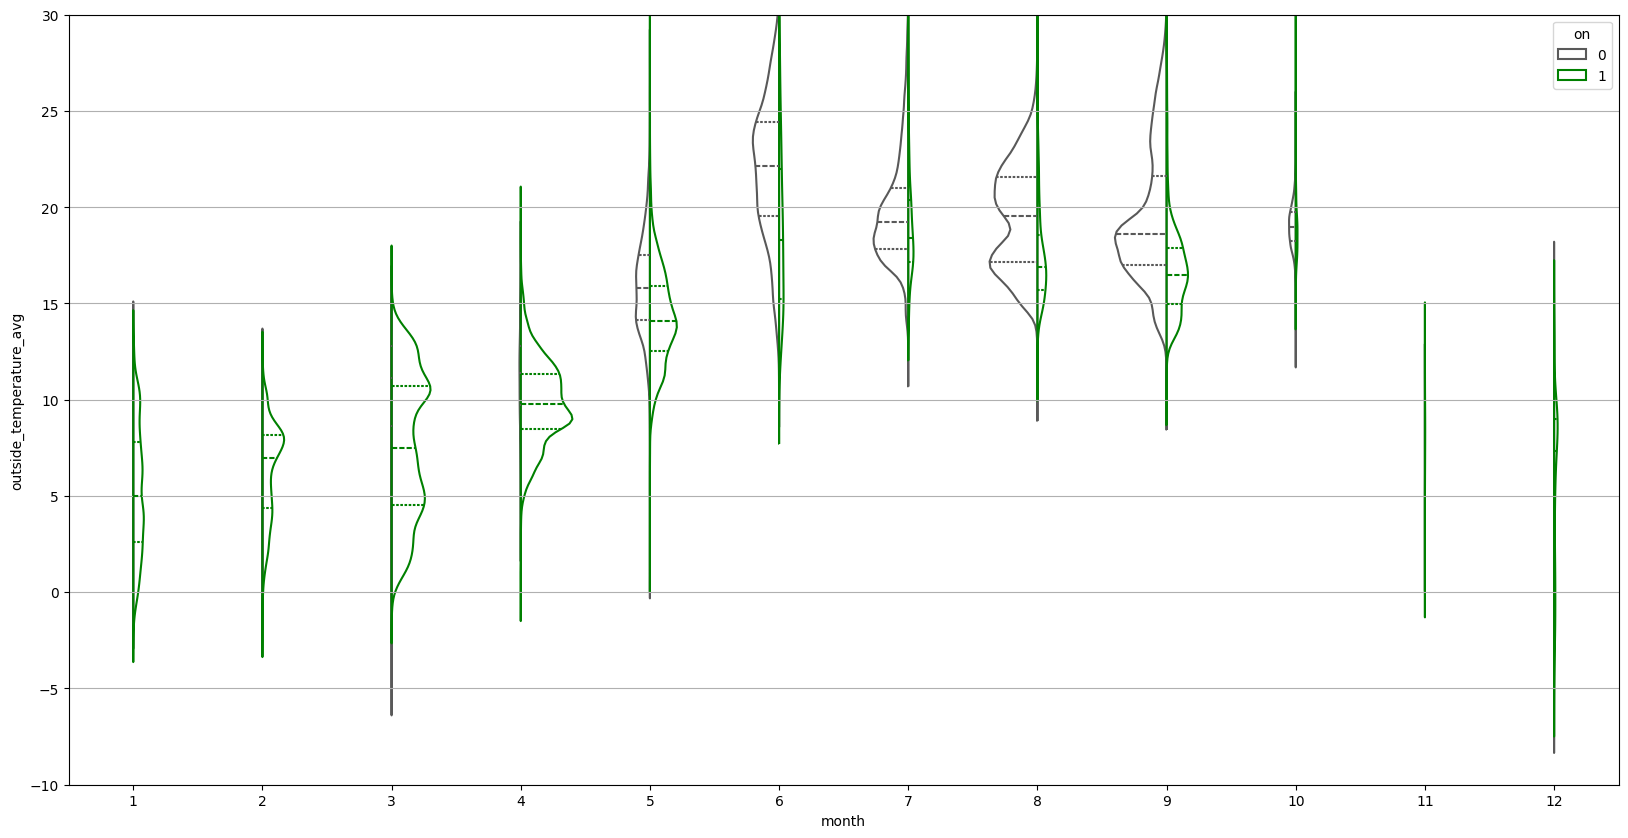

In [69]:
# histogram of average temperature split per month
# violin plot of average temperature split per month
df_cic['on'] = df_cic['heat_delivered'].apply(lambda x: 1 if x > 0 else 0)

sns.violinplot(data=df_cic, # [df_cic['month'].isin([5, 6, 7, 8, 9, 10])]
                x='month',
                y='outside_temperature_avg',
                hue='on', split=True, fill=False, inner='quartile',
                scale='count',
                palette={1: "g", 0: ".35"})
plt.ylim([-10, 30])
plt.grid(axis='y')
#change figure size
plt.rcParams['figure.figsize'] = [20, 10]
plt.show()

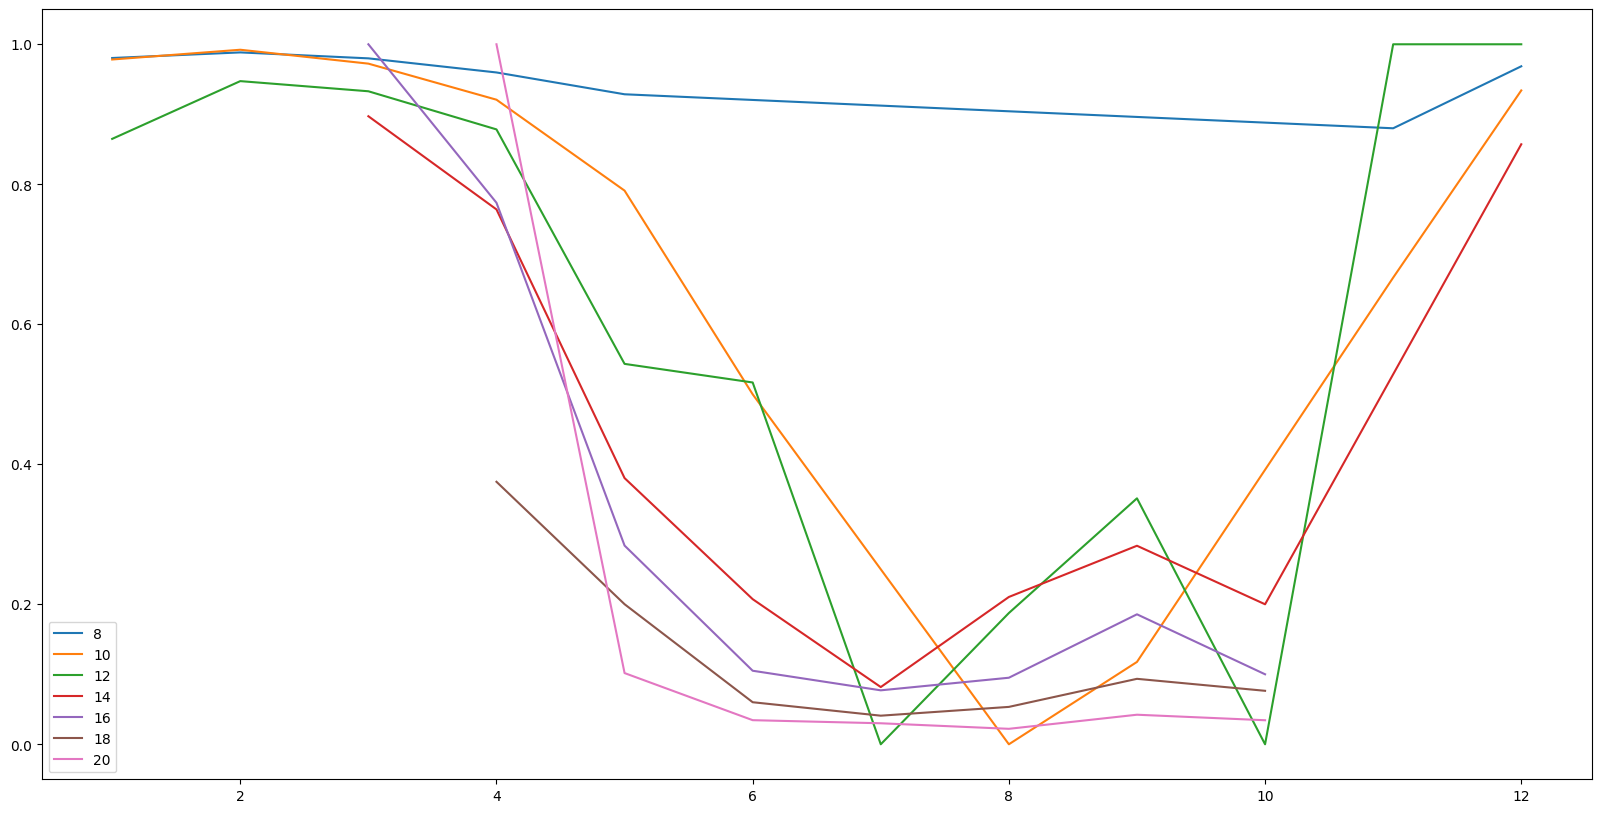

In [74]:
# 
for temp in range(8, 22, 2):
    plt.plot(df_cic[df_cic['outside_temperature_avg'].round(0) == temp].groupby('month').aggregate({'on': 'mean'}))
plt.legend(range(8, 22, 2))
plt.show()

# df_cic[df_cic['outside_temperature_avg'].round(0) == 15].groupby('month').aggregate({'on': 'mean', 'outside_temperature_avg': 'mean', 'heat_delivered': 'mean', 'cic_id':'count'})

# plot correlation matrix
corr = df_total.corr().stack().reset_index(name="correlation")


g = sns.relplot(
    data=corr,
    x="level_0", y="level_1", hue="correlation", size="correlation",
    palette="vlag", hue_norm=(-1, 1), edgecolor=".7",
    height=10, sizes=(50, 250), size_norm=(-.2, .8),
)

# Tweak the figure to finalize
g.set(xlabel="", ylabel="", aspect="equal")
g.despine(left=True, bottom=True)
g.ax.margins(.02)
for label in g.ax.get_xticklabels():
    label.set_rotation(90)

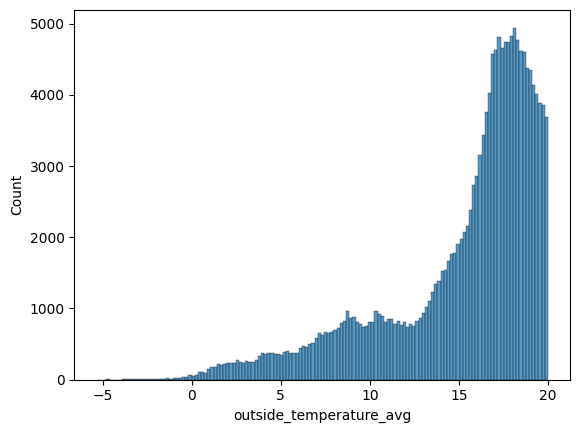

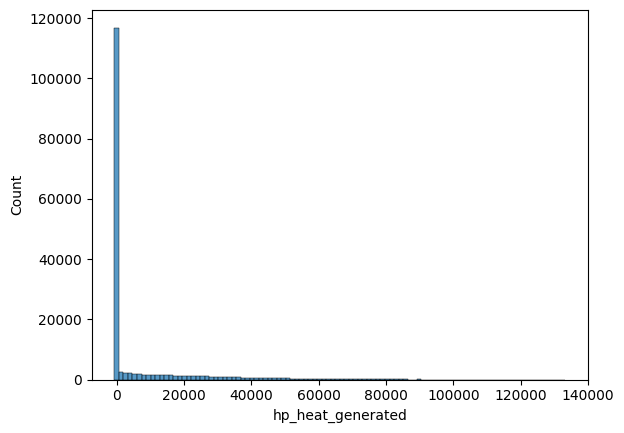

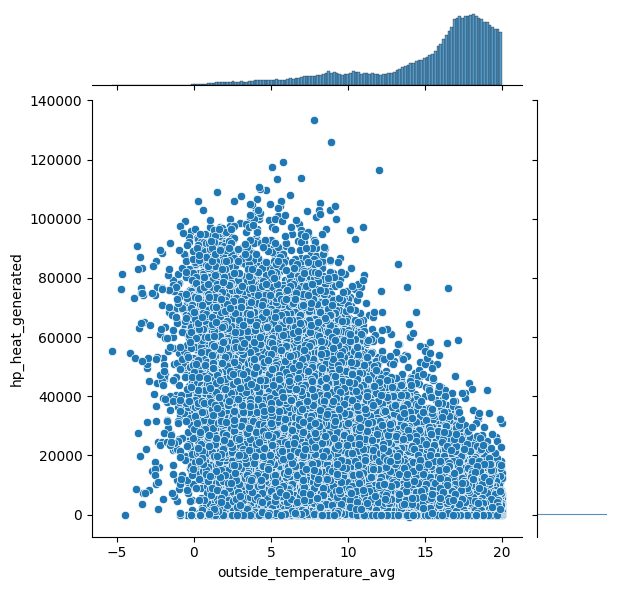

In [38]:
# histograms of temperature
sns.histplot(data=X, x="outside_temperature_avg", multiple="stack")
plt.show()

# histogram of heat generated
sns.histplot(data=y, x="hp_heat_generated", multiple="stack", bins=100)
plt.show()

sns.jointplot(data=df_total, x="outside_temperature_avg", y="hp_heat_generated")
plt.show()

## classification model

In [90]:
# create a boolean y column to determine if heat pump is active
y_bool = (y > 0).astype(int)

In [91]:
# test train split
X_train, X_test, y_bool_train, y_bool_test = train_test_split(X, y_bool, 
                                                    test_size=0.2, 
                                                    random_state=1234)

In [92]:
from sklearn.linear_model import LogisticRegression

# logistic regression including room temperatures and setpoints
logreg_roomtemp = LogisticRegression(max_iter=1000, random_state=42)
logreg_roomtemp.fit(X_train, y_bool_train)

# Predict on the test set
y_pred = logreg_roomtemp.predict(X_test)

# Evaluate the model's performance
train_accuracy = logreg_roomtemp.score(X_train, y_bool_train)
print('train accuracy: ',train_accuracy)
# Predict on the test set and evaluate the accuracy
y_bool_pred = logreg_roomtemp.predict(X_test)
test_accuracy = logreg_roomtemp.score(X_test, y_bool_test)
print('test accuracy: ', test_accuracy)

/Users/noutneijmeijer/Documents/quatt_data_analysis/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


train accuracy:  0.9229106408890242
test accuracy:  0.924343907933995


/Users/noutneijmeijer/Documents/quatt_data_analysis/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [93]:
# Extract feature importance from logistic regression coefficients
feature_importance = pd.DataFrame({
    'Feature': X_train_no_setpoint.columns,
    'Importance': logreg.coef_[0]
})

# Sort by absolute importance
feature_importance['Abs_Importance'] = feature_importance['Importance'].abs()
feature_importance_sorted = feature_importance.sort_values(by='Abs_Importance', ascending=False)

feature_importance_sorted


,Feature,Importance,Abs_Importance
2,outside_temperature_max,-0.135457,0.135457
0,outside_temperature_avg,-0.130827,0.130827
1,outside_temperature_min,-0.128485,0.128485
5,referentie_warmtevraag_per_m2,0.064498,0.064498
3,month,-0.061914,0.061914
7,oppervlakte,-0.015697,0.015697
10,stookgrens,0.013988,0.013988
18,woning_type_ordinal,0.003222,0.003222
15,Dubbel glas,0.001181,0.001181
13,Dakisolatie,0.001138,0.001138


In [94]:
# model without roomtemp
X_train_no_roomtemp = X_train.drop(['room_temperature_avg',
                                    'room_temperature_min',
                                    'room_temperature_max'], axis=1)
X_test_no_roomtemp = X_test.drop(['room_temperature_avg',
                                    'room_temperature_min',
                                    'room_temperature_max'], axis=1)
# logistic regression including room temperatures and setpoints
logreg_setpoint = LogisticRegression(max_iter=1000, random_state=42)
logreg_setpoint.fit(X_train_no_roomtemp, y_bool_train)

# Predict on the test set
y_pred = logreg_setpoint.predict(X_test_no_roomtemp)

# Evaluate the model's performance
train_accuracy = logreg_setpoint.score(X_train_no_roomtemp, y_bool_train)
print('train accuracy: ',train_accuracy)
# Predict on the test set and evaluate the accuracy
y_bool_pred = logreg_setpoint.predict(X_test_no_roomtemp)
test_accuracy = logreg_setpoint.score(X_test_no_roomtemp, y_bool_test)
print('test accuracy: ', test_accuracy)

/Users/noutneijmeijer/Documents/quatt_data_analysis/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


train accuracy:  0.9101004719135333
test accuracy:  0.9101564878524021


/Users/noutneijmeijer/Documents/quatt_data_analysis/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [95]:
# model without roomtemp and setpoint
X_train_no_setpoint = X_train.drop(['room_temperature_avg',
                                    'room_temperature_min',
                                    'room_temperature_max',
                                    'room_set_temperature_avg',
                                    'room_set_temperature_max',
                                    'room_set_temperature_min'], axis=1)
X_test_no_setpoint = X_test.drop(['room_temperature_avg',
                                    'room_temperature_min',
                                    'room_temperature_max',
                                    'room_set_temperature_avg',
                                    'room_set_temperature_max',
                                    'room_set_temperature_min'], axis=1)

# logistic regression including room temperatures and setpoints
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_no_setpoint, y_bool_train)

# Predict on the test set
y_pred = logreg.predict(X_test_no_setpoint)

# Evaluate the model's performance
train_accuracy = logreg.score(X_train_no_setpoint, y_bool_train)
print('train accuracy: ',train_accuracy)
# Predict on the test set and evaluate the accuracy
y_bool_pred = logreg.predict(X_test_no_setpoint)
test_accuracy = logreg.score(X_test_no_setpoint, y_bool_test)
print('test accuracy: ', test_accuracy)

/Users/noutneijmeijer/Documents/quatt_data_analysis/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


train accuracy:  0.8606485005328056
test accuracy:  0.8607440784265968


/Users/noutneijmeijer/Documents/quatt_data_analysis/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## ...

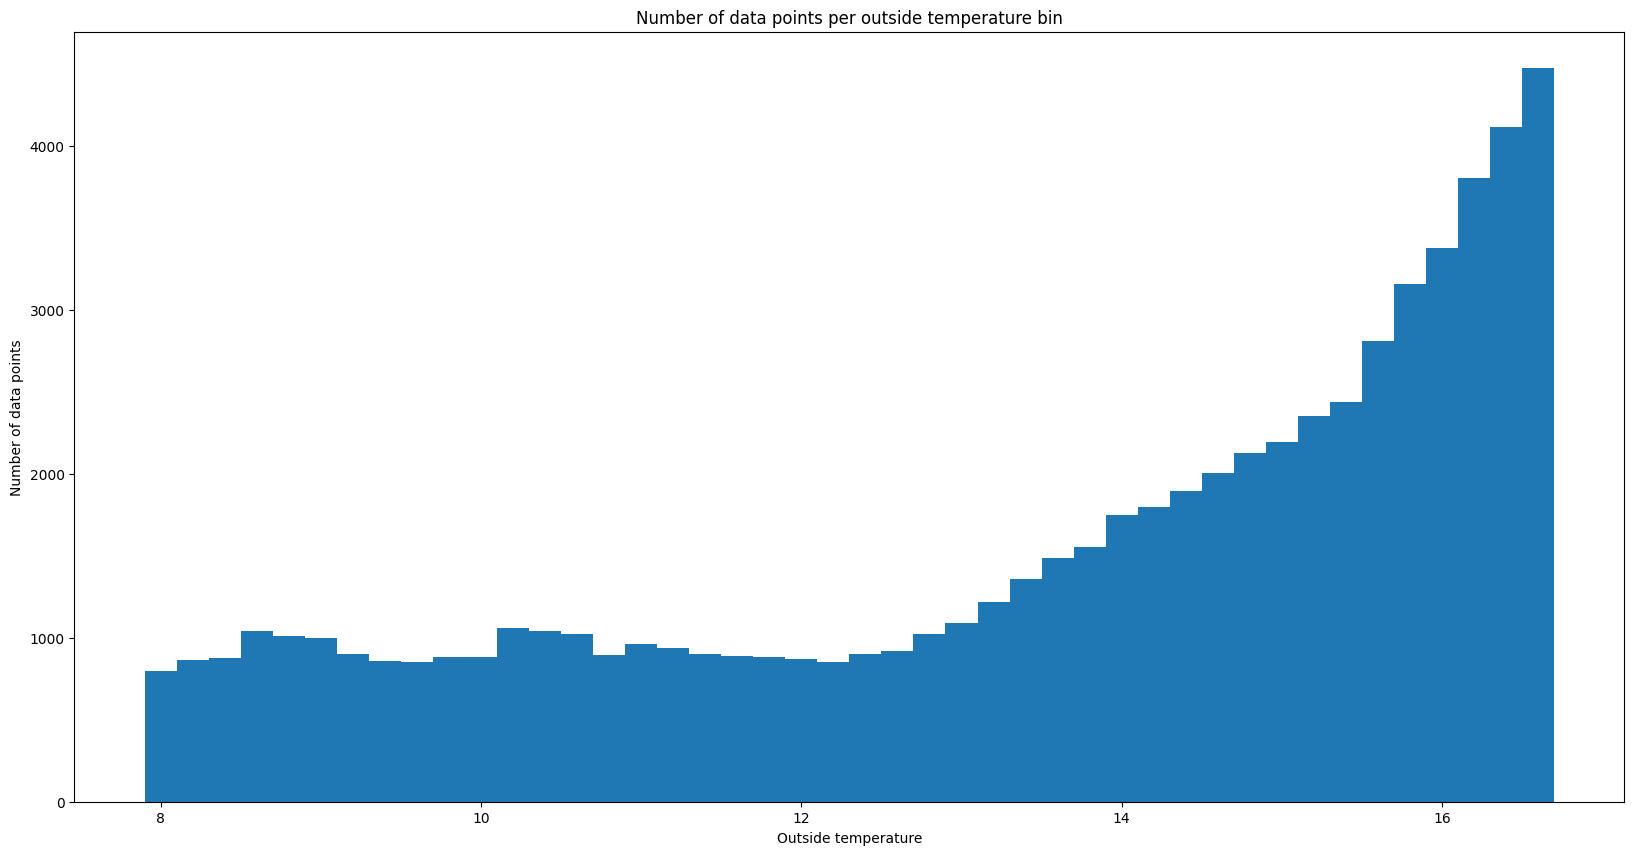

In [96]:
# Define the temperature range with steps of between 8 and 17
temperature_range = np.arange(8, 17, 0.2)
# temperature_range = range(8, 17)

#count  number of samples in each bin in temperature range in X_test
counts = np.histogram(X['outside_temperature_avg'], bins=temperature_range)[0]
# plot number of data points in each bin
plt.bar(temperature_range[:-1], counts, width=0.2)
plt.xlabel('Outside temperature')
plt.ylabel('Number of data points')
plt.title('Number of data points per outside temperature bin')
plt.show()


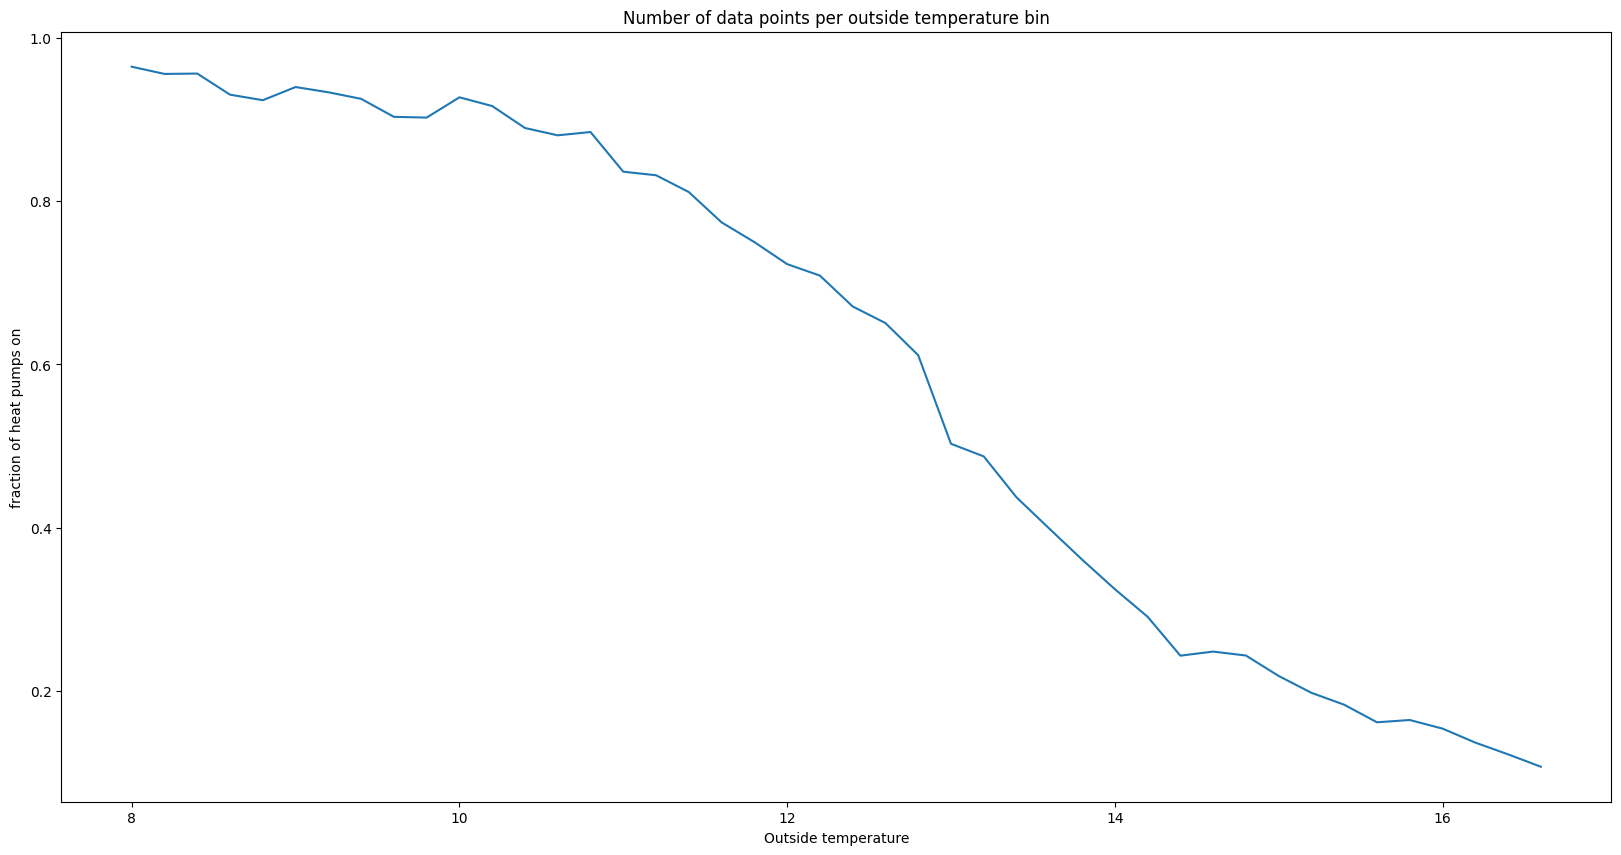

In [97]:
# plot for each temperature the fraction of samples for with heat_delivered > 0
# count number of samples for which heat_delivered > 0
counts_on = np.histogram(df_total[df_total['hp_heat_generated']>0]['outside_temperature_avg'], bins=temperature_range)[0]
counts_tot = np.histogram(df_total['outside_temperature_avg'], bins=temperature_range)[0]
# plot number of data points in each bin
plt.plot(temperature_range[:-1], counts_on/counts_tot)
plt.xlabel('Outside temperature')
plt.ylabel('fraction of heat pumps on')
plt.title('Number of data points per outside temperature bin')
plt.show()

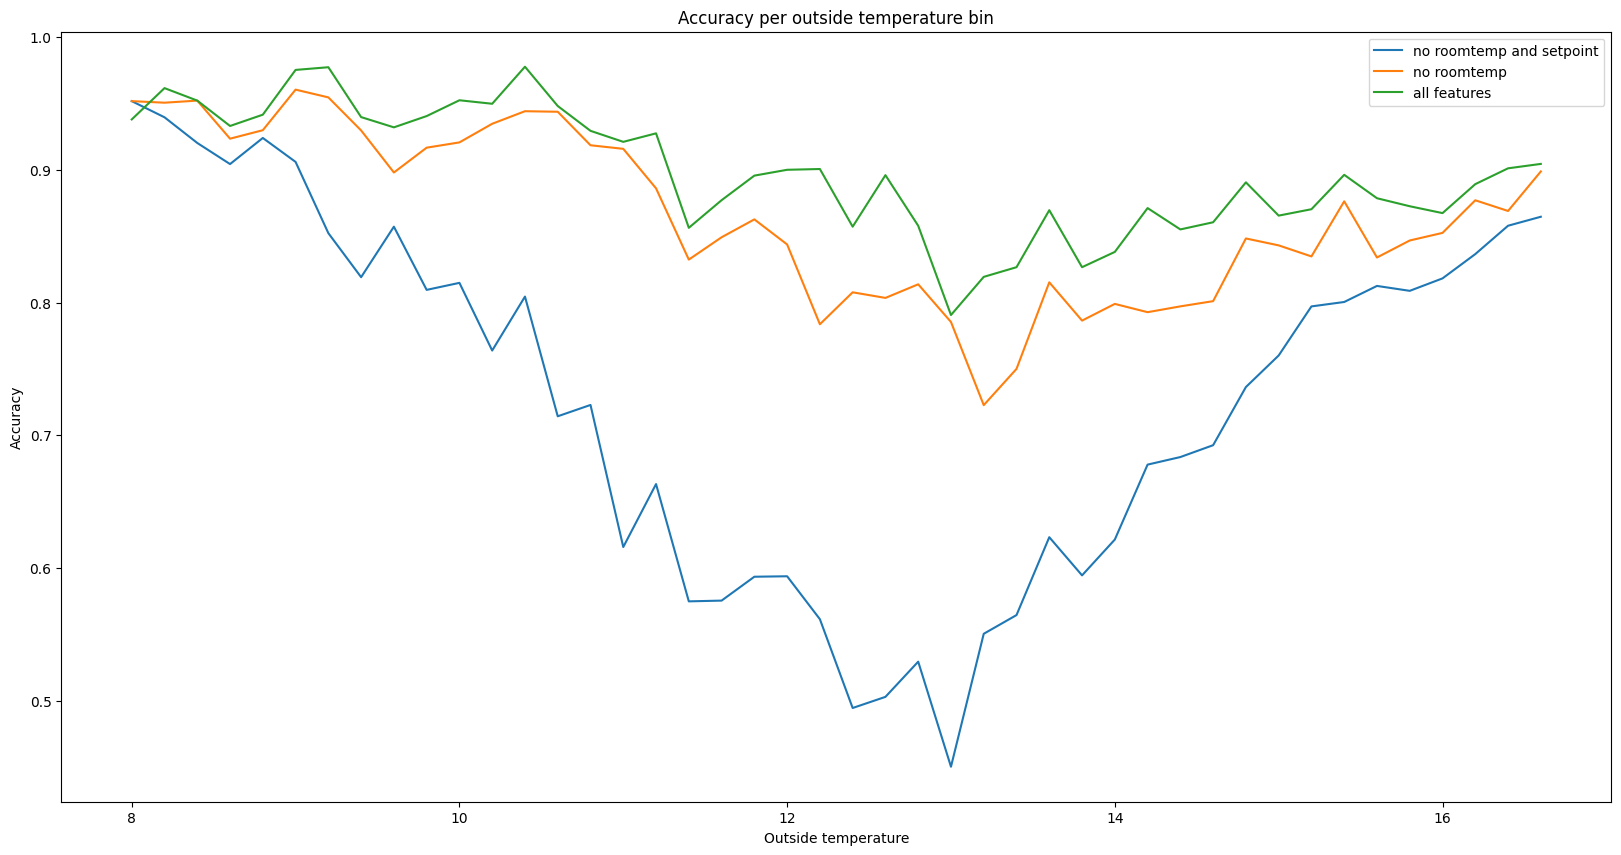

In [98]:
# for each temperature group get the test accuracy of each model
def compute_accuracy_for_temp_range(model, X_test_subset, y_test_subset, temperature_range):
    scores = []
    for i in range(0,len(temperature_range)-1):
        t_min = temperature_range[i]
        t_max = temperature_range[i+1]
        X_temp = X_test_subset[(X_test_subset['outside_temperature_avg']>t_min) 
                               & (X_test_subset['outside_temperature_avg']<=t_max)]
        y_temp = y_test_subset[(X_test_subset['outside_temperature_avg']>t_min) 
                               & (X_test_subset['outside_temperature_avg']<=t_max)]
        if len(X_temp) > 0:
            scores.append(model.score(X_temp, y_temp))
    return scores

# compute accuracy for each temperature range
scores_1 = compute_accuracy_for_temp_range(logreg, X_test_no_setpoint, y_bool_test, temperature_range)
scores_2 = compute_accuracy_for_temp_range(logreg_setpoint, X_test_no_roomtemp, y_bool_test, temperature_range)
scores_3 = compute_accuracy_for_temp_range(logreg_roomtemp, X_test, y_bool_test, temperature_range)

# plot accuracy for each temperature range
plt.plot(temperature_range[:-1], scores_1, label='no roomtemp and setpoint')
plt.plot(temperature_range[:-1], scores_2, label='no roomtemp')
plt.plot(temperature_range[:-1], scores_3, label='all features')
plt.xlabel('Outside temperature')
plt.ylabel('Accuracy')
plt.title('Accuracy per outside temperature bin')
plt.legend()
plt.show()



